# 1. Unconfined Aquifer Test - Vennebulten
**This example is taken from Kruseman et al. (1970).**

## Introduction and Conceptual Model

In aquifer tests in unconfined aquifers there is also the important vertical component to flow to the well. The drawdown data shows what is called delayed water table response, a distinguishable S-shape in the log-log plot. The early times of the drawdown, the drawdown behaves as a confined aquifer, when the aquifer releases the elastic storage, however as pumping continues the water table storage begins to be released generating further drawdown and the S-shape.

This test conducted in Vennebulten, the Netherlands, is reported in Kruseman et al. (1970). The cross-section is consisted by a first layer up to 6 m depth of very fine and loamy sands, followed by coarse sands until 21 m depth.

In this example, we will reproduce the work of Xinzhu (2020) that compared different conceptualizations in TTim to different solutions presented in the original report (Kruseman et al., 1970) and in different softwares, MLU (Carson & Randall, 2012) and AQTESOLV (Duffield, 2007).

The screen of the pumping well is placed between 10 and 21 meters depth and pumping has taken place for 25 hours at a rate of 873 m3/d. The available data of drawdown comes from two piezometers, a shallow one, screened at depth of 3 m, and a deeper one, screened in the depths between 12 to 19 m. Both wells are located 90 m from the pumping well.

The conceptual model of the aquifer can be seen below:

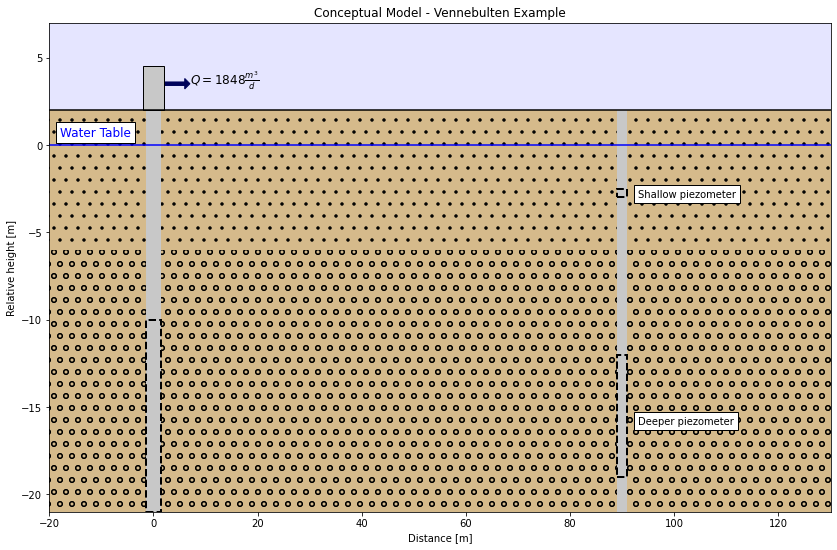

In [95]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1,1,1)
#sky
sky = plt.Rectangle((-20,2), width = 150, height = 5, fc = 'b', zorder=0, alpha=0.1)
ax.add_patch(sky)

#Aquifer:
ground = plt.Rectangle((-20,-6), width = 150, height = 8, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9, hatch = '.')
ax.add_patch(ground)

#Aquifer 2:
ground2 = plt.Rectangle((-20,-21), width = 150, height = 15, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9, hatch = 'o')
ax.add_patch(ground2)


well = plt.Rectangle((-1.5,-21), width = 3, height = 23, fc = np.array([200,200,200])/255, zorder=1)
ax.add_patch(well)

#Wellhead
wellhead = plt.Rectangle((-2,2),width = 4, height = 2.5, fc = np.array([200,200,200])/255, zorder=2, ec='k')
ax.add_patch(wellhead)

#Screen for the well:
screen = plt.Rectangle((-1.5,-21), width = 3, height = 11, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x = 2,y = 3.5, dx = 5, dy = 0, color = "#00035b")
ax.add_patch(pumping_arrow)
ax.text(x = 7, y = 3.5, s = r'$ Q = 873 \frac{m^3}{d}$', fontsize = 'large' )

#Piezometers
piez1 =plt.Rectangle((89,-21), width = 2, height = 23, fc = np.array([200,200,200])/255, zorder=1)
screen_piez_1 = plt.Rectangle((89,-19), width = 2, height = 7, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle((89,-3), width = 2, height = 0.5, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_2.set_linewidth(2)

ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)


#last line
line = plt.Line2D(xdata= [-200,1200], ydata = [2,2], color = "k")
ax.add_line(line)

#Water table
line2 = plt.Line2D(xdata = [-200,1200], ydata = [0,0], color = 'b')
ax.add_line(line2)

ax.text(-18,0.5, s = 'Water Table', fontsize = 'large', color = 'b',bbox = {'fc' : 'w'})
ax.text(93, -3, s = 'Shallow piezometer', bbox = {'fc' : 'w'})
ax.text(93, -16, s = 'Deeper piezometer', bbox = {'fc' : 'w'})

ax.set_xlim([-20,130])
ax.set_ylim([-21,7])
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Relative height [m]')
ax.set_title('Conceptual Model - Vennebulten Example');

## Step 1. Load the required libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ttim import *
import pandas as pd

## Step 2. Set basic parameters for the model

In [5]:
b = -21 #aquifer thickness in m
r = 90 #distance from observation wells to pumping well in m
Q = 873 #constant discharge in m^3/d

## Step 3. Load data of the two piezometers

In [6]:
data1 = np.loadtxt('data/venne_shallow.txt', skiprows=1)
ts = data1[:, 0] / 60 / 24 #convert min to days
hs = data1[:, 1]

data2 = np.loadtxt('data/venne_deep.txt', skiprows=1)
td = data2[:, 0] / 60 / 24 #convert min to days
hd = data2[:, 1]

## Step 4. Create conceptual one-layer model

The Both Kruseman et al. (1970) and the AQTESOLV solution, that uses the Neuman method (Neumann, 1969), assume a one layer uncofined model.
To compare TTim with both, we begin by modelling a one-layer aquifer.

For unconfined test, the preffered method for modelling is to use the ```Model3D``` class. ```Model3D``` assumes the system is a vertical stacking of aquifer layers. Vertical flow is computed between layers by computing the vertical resistance between layers. Vertical resistance between the aquifer layers is computed as the resistance from the middle of one layer to the middle of the next layer. Vertical anistotropy can be specified for each layer.

Model construction is similar to the ```ModelMaq``` class. We detail it below:

For our Model3D model we have to set:

- The hydraulic conductivity: ```kaq``` this is a list/array with a float element for every aquifer, example: ```[kaq0,kaq1]```. We can also set a float value, in this case the same ```kaq``` is assumed for every layer.
- The top and bottom of each aquifer: ```z``` defined by a list/array ```[zt0,zb0,zt1,zb1,...]```, where the inputs are a sequence of top and bottoms of the aquifer layers.
- The specific storage: ```Saq```, this is a list/array with a float element for every aquifer, example: ```[Saq0,Saq1]```. We can also set a float value, in this case the same ```Saq``` is assumed for every layer.
- The minimum time for which TTim solve the groundwater flow: ```tmin```, a float.
- And the maximum time: ```tmax```, float.
- TTim automatically assumes the ```topboundary``` is confined. In this case we are also assuming the ```topboundary``` is confined, so we do not need to set this parameter. In the code example, the parameter is set for clarity.
- The vertical anisotropy: ```kzoverkh```, which is the vertical hydraulic conductivity divided by the horizontal conductivity. This is a list/array with a float element for every aquifer, example: ```[kzoverkh0,kzoverkh1]```. We can also set a float value, in this case the same ```kzoverkh``` is assumed for every layer. If this parameter is not set, an isotropic model is considered: ```kzoverkh = 1```
- ```phreatictop```: Is a boolean (True/False). If ```True```, the first element in ```Saq``` is considered a phreatic storage (Specific Yield) and is not multiplied by the layer thickness. The default value is ```True```. This is an important variable for unconfined aquifer test and we will show below how to set this below.

To reproduce the one-layer aquifer model in Kruseman et al. (1970), we will actually build a two-layer Model3D model. The first layer is a very thin (0.1 m thick) layer with phreatic storage, followed by the 21 m thick aquifer layer. This is how TTim accounts for the water table storage in the unconfined situation.


In [2]:
# Model Figure - One - layer model

In [27]:
ml_1 = Model3D(kaq=10, z=[0,-0.1, b], Saq=[0.1,1e-4], tmin=1e-4, tmax=1.1, kzoverkh = 1, phreatictop = True)
w_1 = Well(ml_1, xw=0, yw=0, rw=0.1, tsandQ=[(0, Q)])
ml_1.solve()

self.neq  1
solution complete


## Step 5. Model calibration

Model Calibration is done in TTim using the ```Calibrate``` object. TTim calibrates the parameters by minimizing an objective function using a non-linear least-squares fitting algorithm. The objective function used is the sum of the squares of the residuals calculated as:

$$\sum_n (h_o - h_c)^2$$,

where $h_0$ is the observed heads and $h_c$ is the calculated heads by the model.

and TTim uses ```lmfit```, a python package for non-linear least-squares minimization (Newville et al. 2014), to find the optimal parameters that minimize the residuals.

For the calibration of our groundwater model we proceed by creating a calibration object with the ```Calibrate``` class. The ```Calibrate``` object takes the model ```ml``` as argument.
We then set the parameters we are adjusting:
- Hydraulic conductivity: ```kaq0_1``` (Hydraulic conductivity of layer 0 and 1)
- Specific Yield ```Saq0``` (Phreatic Storage in our case (Check Step 4 - Model Construction))
- Specif Storage ```Saq1``` of layer 1.

with the ```.set_parameter``` method.

- ```.set_parameter``` takes two arguments:
- ```name``` is the parameter name, a string, where the letters define the parameter. The possible values are "kaq", "Saq" or 'c', and they represent hydraulic conductivity, Specific storage and resistance to vertical flow, respectively. The letters are followed by a number, that define the layer of that parameter. For the example ```"kaq0"``` means the hydraulic conductivity of the layer 0. In our multilayer model we can extend the numbering to adjust one parameters for various layers in that case, we write the number of the first layer followed by a underline "_" and the number of the last layer, for example in our first parameter ```kaq0_1```, which means the hydraulic conductivity for layers 0 to 1
    - ```initial```is the initial guess value for the fitting algorithmn.

We can also add the optional parameters:
- ```pmin``` and ```pmax```, which are floats that define the minimum and maximum possible values for the parameter.

In TTim, all parameters except hydraulic conductivity and specific storage of aquifers, and resistance of leaky-layers must be calibrated with the ```.set_parameter_by_reference``` method.

Here we use the method ```.set_parameter_by_reference``` to calibrate the ```kzoverkh``` parameter in our aquifer.

```.set_parameter_by_reference``` takes the following arguments:
* ```name```: string of the parameter name
* ```parameter```: numpy-array with the parameter to be optimized. It should be specified as a reference, for example, in our case: ```ml_1.aq.kzoverkh[0:]``` referencing to the parameter ```kzoverkh``` in object ```ml_1```.
* ```initial```: float with the initial guess for the parameter value.
* ```pmin```and ```pmax```: floats with the minimum and maximum values allowed for the parameter to be optimized. If not specified these will be defined as ```-np.inf``` and ```np.inf```.

We add the observation data using the ```.series``` method. The arguments are:
 - ```name```: string with the observation name
 - ```x``` and ```y```: float positions of the observation
 - ```t```: the array of observation times
 - ```h```: the array of observed drawdowns
 - ```layer```: integer. The layer of the observation (0 indexed)

 
After everything is set, we call the ```.fit``` method to compute the calibration.

### Step 5.1. Calibrating the one layer model with the shallow piezometer

We begin the initial model adding the shallow observation well as the observation for the residuals calibration. And we calibrate hydraulic conductivity, specific yield and specific storage of our one layer uncofined aquifer:

In [29]:
#calibrate with data of shallow piezometer
#unknown parameters: kaq, Saq
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name='kaq0_1', initial=10)
ca_1.set_parameter(name='Saq0', initial=0.2)
ca_1.set_parameter(name='Saq1', initial=1e-4, pmin = 0)
ca_1.set_parameter_by_reference(name = 'kzoverkh', parameter=ml_1.aq.kzoverkh[:], initial=1, pmin = 1e-5)
ca_1.series(name='obs', x=r, y=0, t=ts, h=hs, layer=0)
ca_1.fit()

.............................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 19
    # variables        = 4
    chi-square         = 2.4178e-04
    reduced chi-square = 1.6119e-05
    Akaike info crit   = -206.166286
    Bayesian info crit = -202.388530
[[Variables]]
    kaq0_1:    136.113285 +/- 13.4624408 (9.89%) (init = 10)
    Saq0:      0.01620305 +/- 0.03081655 (190.19%) (init = 0.2)
    Saq1:      2.4415e-05 +/- 0.00133103 (5451.62%) (init = 0.0001)
    kzoverkh:  3.91190019 +/- 53.6951392 (1372.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Saq0, Saq1)       = -0.998
    C(Saq0, kzoverkh)   =  0.923
    C(Saq1, kzoverkh)   = -0.910
    C(kaq0_1, Saq0)     = -0.902
    C(kaq0_1, Saq1)     =  0.885
    C(kaq0_1, kzoverkh) = -0.823


In [30]:
display(ca_1.parameters)
print('RMSE:', ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_1,136.113285,13.462441,9.890615,-inf,inf,10,"[136.11328466342897, 136.11328466342897]"
Saq0,0.016203,0.030817,190.189847,-inf,inf,0.2,[0.01620304936519204]
Saq1,0.000024,0.001331,5451.617526,0.00000,inf,0.0001,[2.4415366180585707e-05]
kzoverkh,3.9119,53.695139,1372.610155,0.00001,inf,1,"[3.9119001880095454, 3.9119001880095454]"


RMSE: 0.0035672692075366533


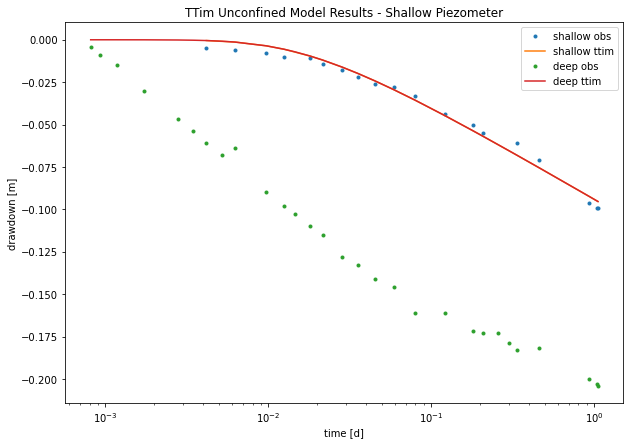

In [31]:
hs_1 = ml_1.head(r, 0, ts)
hd_1 = ml_1.head(r, 0, td)
plt.figure(figsize=(10, 7))
plt.semilogx(ts, hs, '.', label='shallow obs')
plt.semilogx(ts, hs_1[0], label='shallow ttim')
plt.semilogx(td, hd, '.', label='deep obs')
plt.semilogx(td, hd_1[0], label='deep ttim')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('TTim Unconfined Model Results - Shallow Piezometer')
plt.legend();

### Step 5.2. Calibrating the one layer model with the deeper piezometer

In this second approach we adjust the model to the deeper piezometer, as done by Kruseman and de Ridder (1970).

In [79]:
#calibrate with data of deeper piezometer
#unknown parameters: kaq, Saq, kzoverkh
ca_2 = Calibrate(ml_1)
ca_2.set_parameter(name='kaq0_1', initial=10, pmin = 1e-8)
ca_2.set_parameter(name='Saq1', initial=1e-4, pmin = 1e-5)
ca_2.set_parameter(name='Saq0', initial=0.2, pmin = 1e-8)
ca_2.set_parameter_by_reference(name = 'kzoverkh', parameter=ml_1.aq.kzoverkh[:], initial=0.1, pmin = 1e-8, pmax = 10)
ca_2.series(name='obs', x=r, y=0, t=td, h=hd, layer=0)
ca_2.fit()

....................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 257
    # data points      = 29
    # variables        = 4
    chi-square         = 0.00113404
    reduced chi-square = 4.5362e-05
    Akaike info crit   = -286.328575
    Bayesian info crit = -280.859392
[[Variables]]
    kaq0_1:    129.103094 +/- 5.89017553 (4.56%) (init = 10)
    Saq1:      1.0057e-05 +/- 4.3398e-06 (43.15%) (init = 0.0001)
    Saq0:      4.1011e-05 +/- 1.2716e-05 (31.01%) (init = 0.2)
    kzoverkh:  0.00587916 +/- 4.5885e-04 (7.80%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Saq1, Saq0)       = -0.895
    C(Saq1, kzoverkh)   = -0.723
    C(kaq0_1, Saq0)     =  0.611
    C(kaq0_1, Saq1)   

In [80]:
display(ca_2.parameters)
print('RMSE:', ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_1,129.103094,5.890176,4.562381,1.000000e-08,inf,10,"[129.10309350756515, 129.10309350756515]"
Saq1,0.00001,0.000004,43.153346,1.000000e-05,inf,0.0001,[1.0056648519829459e-05]
Saq0,0.000041,0.000013,31.005926,1.000000e-08,inf,0.2,[4.1011154635284264e-05]
kzoverkh,0.005879,0.000459,7.804728,1.000000e-08,10.0,0.1,"[0.00587915505368052, 0.00587915505368052]"


RMSE: 0.006253395985020136


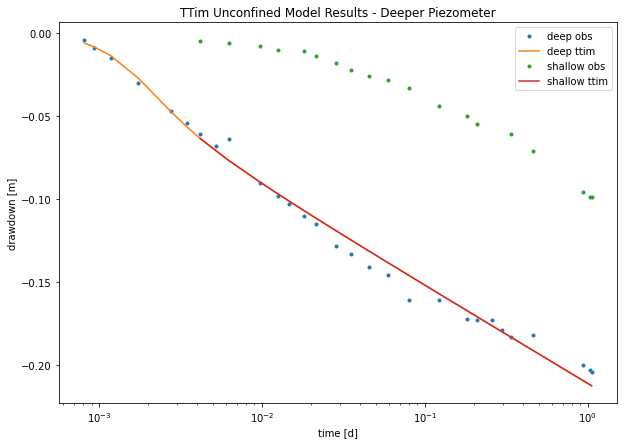

In [81]:
hd_2 = ml_1.head(r, 0, td)
hs_2 = ml_1.head(r, 0, ts)
plt.figure(figsize=(10, 7))
plt.semilogx(td, hd, '.', label='deep obs')
plt.semilogx(td, hd_2[0], label='deep ttim')
plt.semilogx(ts, hs, '.', label='shallow obs')
plt.semilogx(ts, hs_2[0], label='shallow ttim')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('TTim Unconfined Model Results - Deeper Piezometer')
plt.legend();

## Step 6. Create conceptual model with n-layers

As we can see in the examples of step 5, the single-layer simplification does not represent the system well as we have a vertical component to flow, shown in the head difference between both piezometers.

We now explore the feature of TTim to create a multi-layer model to better represent the unconfined system and simulate the vertical flow component. We will discretize the aquifer in a 21 layer model, with 1 m thick each.

In [42]:
nlay = 21 #number of layers
zlayers = np.linspace(0, b, nlay + 1) #elevation of each layer
Saq = 1e-4 * np.ones(nlay)
Saq[0] = 0.1 # Setting the first storage as specific yield

The model is created just as in the previous step, however with the new parameters defined above:

In [44]:
ml_2 = Model3D(kaq=10, z=zlayers, Saq=Saq, kzoverkh=0.1, phreatictop=True, \
              tmin=1e-4, tmax=1.1)
w_2 = Well(ml_2, xw=0, yw=0, rw=0.1, tsandQ=[(0, Q)], layers=range(nlay))
ml_2.solve()

self.neq  21
solution complete


## Step 7. Calibrate multi-layer model with the two piezometers simultaneously

Now we can take advantage of TTim multi-layer model to try to fit the unconfined model with both piezometers at the same time.
For this initial assumption, we assume the aquifer has one hydraulic conductivity and storage parameters

The unknown parameters are: kaq, Saq, kzoverkh.

Now on the ```series``` method, we have to remember to set a different layer for each piezometer corresponding to the depth of the screen of each.

In [45]:
ca_3 = Calibrate(ml_2)
ca_3.set_parameter(name='kaq0_20', initial=10)
ca_3.set_parameter(name='Saq0', initial=0.2)
ca_3.set_parameter(name='Saq1_20', initial=1e-4)
ca_3.set_parameter_by_reference(name='kzoverkh', parameter=ml_2.aq.kzoverkh[:], \
                               initial=0.1, pmin=0.01)
ca_3.series(name='obs1', x=r, y=0, layer=1,t=ts, h=hs)
ca_3.series(name='obs2', x=r, y=0, layer=15, t=td, h=hd)
ca_3.fit(report=True)

.............................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 48
    # variables        = 4
    chi-square         = 0.00474158
    reduced chi-square = 1.0776e-04
    Akaike info crit   = -434.684078
    Bayesian info crit = -427.199274
[[Variables]]
    kaq0_20:   31.6096805 +/- 0.80181268 (2.54%) (init = 10)
    Saq0:      0.05531213 +/- 0.00394087 (7.12%) (init = 0.2)
    Saq1_20:   3.4685e-05 +/- 2.4423e-06 (7.04%) (init = 0.0001)
    kzoverkh:  0.01000645 +/- 2.0489e-04 (2.05%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_20, kzoverkh) = -0.590
    C(Saq0, kzoverkh)    = -0.289
    C(kaq0_20, Saq1_20)  = -0.198
    C(kaq0_20, Saq0)     = -0.187


In [46]:
display(ca_3.parameters)
print('RMSE:', ca_3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_20,31.60968,0.801813,2.536605,-inf,inf,10,"[31.609680491870815, 31.609680491870815, 31.60..."
Saq0,0.055312,0.003941,7.124785,-inf,inf,0.2,[0.05531212724692188]
Saq1_20,0.000035,0.000002,7.041406,-inf,inf,0.0001,"[3.4684697166078037e-05, 3.4684697166078037e-0..."
kzoverkh,0.010006,0.000205,2.047616,0.01,inf,0.1,"[0.010006449757717473, 0.010006449757717473, 0..."


RMSE: 0.009938964094229851


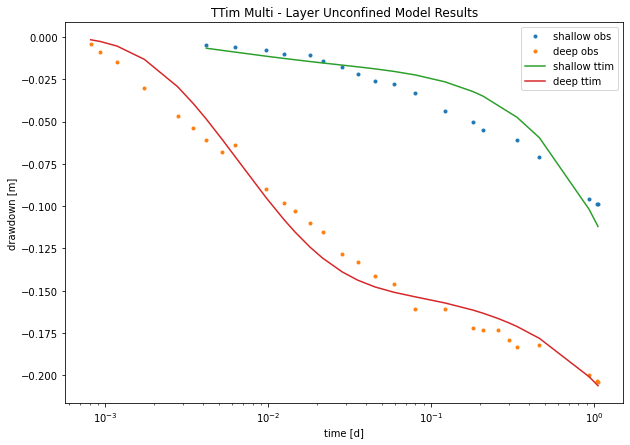

In [47]:
hs_3 = ml_2.head(x=r, y=0, t=ts, layers=1)
hd_3 = ml_2.head(x=r, y=0, t=td, layers=15)
plt.figure(figsize = (10, 7))
plt.semilogx(ts, hs, '.', label='shallow obs')
plt.semilogx(td, hd, '.', label='deep obs')
plt.semilogx(ts, hs_3[0], label='shallow ttim')
plt.semilogx(td, hd_3[0], label='deep ttim')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('TTim Multi - Layer Unconfined Model Results')
plt.legend();

We already see significant improvement from the previous single layer model. The fit is better and we have a much better confidence interval on the parameters. The AIC and BIC indicators have also significantly improved.

What if we take into account the described stratification of the aquifer? In that case we could try to stratify our model into two: The first 6 m and the deeper layers.

## Step 8. Calibration with Stratified Model

In this final example, we will assume the storage is distributed according to the sediment stratification in the aquifer. We will adjust two different ```Saq```values, one for the first 6 m of aquifer and another for the deeper layers. We assume the hydraulic conductivity and the anisotropy is constant.

In [48]:
ml_3 = Model3D(kaq=10, z=zlayers, Saq=Saq, kzoverkh=0.1, phreatictop=True, \
              tmin=1e-4, tmax=1.1)
w_3 = Well(ml_3, xw=0, yw=0, rw=0.1, tsandQ=[(0, Q)], layers=range(nlay))
ml_3.solve()

self.neq  21
solution complete


In [49]:
ca_4 = Calibrate(ml_3)
ca_4.set_parameter(name='kaq0_20', initial=50)
ca_4.set_parameter(name='Saq0', initial=0.1)
ca_4.set_parameter(name='Saq1_7', initial=1e-4, pmin=0)
ca_4.set_parameter(name='Saq7_20', initial=1e-4, pmin=0)
ca_4.set_parameter_by_reference(name='kzoverkh', parameter=ml_3.aq.kzoverkh[:], \
                               initial=0.1, pmin=0)
ca_4.series(name='obs1', x=r, y=0, layer=1,t=ts, h=hs)
ca_4.series(name='obs2', x=r, y=0, layer=15, t=td, h=hd)
ca_4.fit(report=True)

..........................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 103
    # data points      = 48
    # variables        = 5
    chi-square         = 5.6242e-04
    reduced chi-square = 1.3080e-05
    Akaike info crit   = -535.013955
    Bayesian info crit = -525.657950
[[Variables]]
    kaq0_20:   74.6776350 +/- 2.30997491 (3.09%) (init = 50)
    Saq0:      0.02070955 +/- 0.00159014 (7.68%) (init = 0.1)
    Saq1_7:    4.4735e-04 +/- 6.0125e-05 (13.44%) (init = 0.0001)
    Saq7_20:   2.3212e-05 +/- 1.1258e-06 (4.85%) (init = 0.0001)
    kzoverkh:  3.8313e-04 +/- 8.1985e-05 (21.40%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_20, kzoverkh) = -0.966
    C(kaq0_20, Saq7_20)  = -0.758
    C(Saq1_7, kzoverkh)  = -0.747
    C(Saq7_20, kzoverkh) =  0.714
    C(kaq0_20, Saq1_7)   =  0.641
    C(kaq0_20, Saq0)     = -0.627
    C(

In [50]:
display(ca_4.parameters)
print('RMSE:', ca_4.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_20,74.677635,2.309975,3.093262,-inf,inf,50,"[74.67763499768243, 74.67763499768243, 74.6776..."
Saq0,0.02071,0.001590,7.678297,-inf,inf,0.1,[0.02070954750959166]
Saq1_7,0.000447,0.000060,13.440394,0.0,inf,0.0001,"[0.00044734513676525367, 0.0004473451367652536..."
Saq7_20,0.000023,0.000001,4.850362,0.0,inf,0.0001,"[2.321160685458956e-05, 2.321160685458956e-05,..."
kzoverkh,0.000383,0.000082,21.398915,0.0,inf,0.1,"[0.00038312639699511486, 0.0003831263969951148..."


RMSE: 0.003423031570426906


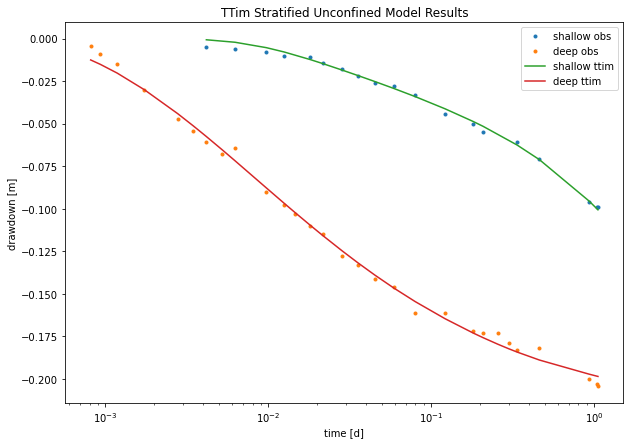

In [51]:
hs_4 = ml_3.head(x=r, y=0, t=ts, layers=1)
hd_4 = ml_3.head(x=r, y=0, t=td, layers=15)
plt.figure(figsize = (10, 7))
plt.semilogx(ts, hs, '.', label='shallow obs')
plt.semilogx(td, hd, '.', label='deep obs')
plt.semilogx(ts, hs_4[0], label='shallow ttim')
plt.semilogx(td, hd_4[0], label='deep ttim')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('TTim Stratified Unconfined Model Results')
plt.legend();

Here we see that the model fit has significantly improved. AIC and BIC indicators are lower than the previous multi-layer model.

## Step 9. Analysis and comparison of model results

### Step 9.1. Analysis of models with single layer

Kruseman and de Ridder (K&dR) applied graphical analysis using the Neuman method considering a single layer unconfined aquifer and the drawdown of the deeper well. The same conceptualization and data has been used by Xinzhu (2020) to model the aquifer paremeter in AQTESOLV (Duffield, 2007), and in MLU (Carlson and Randall, 2012), however for the latter, since MLU is a similar model method as in TTim, Xinzhu used the same approach in this notebook by representing the one-layer unconfined aquifer in a two-layer configuration: a shallow 0.1 m thick with phreatic storage and the aquifer thickness with elastic storage.

The table below summarises the results obtained by each approach

In [78]:
t1 = pd.DataFrame(columns=['k [m/d]', 'Ss [1/m]', 'Sy [-]', 'kz/kh'], \
                 index=['K&dR', 'AQTESOLV', 'MLU', 'ttim'])
t1.loc['K&dR'] = [73, 2.476e-05, 0.005, 0.000548]
t1.loc['AQTESOLV'] = [63.805, 2.663e-05, 0.011, 0.000690]
t1.loc['MLU'] = [74.657, 2.767e-05, 0.005, 0.000737]
t1.loc['ttim'] = ca_2.parameters['optimal'].values 
t1['RMSE'] = ['-', 0.003041, 0.003216, ca_2.rmse()]
t1

,k [m/d],Ss [1/m],Sy [-],kz/kh,RMSE
K&dR,73,0.000025,0.005,0.000548,-
AQTESOLV,63.805,0.000027,0.011,0.00069,0.003041
MLU,74.657,0.000028,0.005,0.000737,0.003216
ttim,136.275503,0.00001,0.000043,0.004599,0.00592


TTim has overal found a different solution than the other presented results. It also could not reach the RMSE of the other solvers.

### Step 9.2. Analysis of multi-layer models

Xinzhu (2020) also applied the multi-layer approach to MLU model and the different results are presented in the table below:

In [21]:
t2 = pd.DataFrame(columns=['k [m/d]', 'Sy [-]', 'Ss [1/m]','kzoverkh'], \
                 index=['MLU', 'ttim-multilayer', 'ttim-stratified Ss'])
t2.loc['MLU'] = [62.657, 0.0012, 2.790e-05, 0.002595]
t2.loc['ttim-multi-layer'] = ca_3.parameters['optimal'].values
t2.iloc[2, 0:2] = ca_4.parameters['optimal'].values[0:2]
t2.iloc[2, 2:4] = ca_4.parameters['optimal'].values[3:5]
t2['RMSE'] = [0.013540, ca_3.rmse(), ca_4.rmse()]
t2

,k [m/d],Sy [-],Ss [1/m],kzoverkh,RMSE
MLU,62.657,0.0012,2.79e-05,0.002595,0.013540
ttim-multilayer,31.5793,0.0554154,3.47254e-05,0.0100151,0.009941
ttim-stratified Ss,74.9209,0.0205783,2.31146e-05,0.000374873,0.003423


The multi-layer approach allowed us to fit both piezometers and better represent the vertical component of flow. However the parameters were sensitive to the conceptualization applied. The stratified model had much larger hydraulic conductivity in comparison to the multi-layer model. In the stratified approach the fit has significantly improved.

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Kruseman, G.P., De Ridder, N.A., Verweij, J.M., 1970. Analysis and evaluationof pumping test data. volume 11. International institute for land reclamation and improvement The Netherlands.
* Neuman, S.P., Witherspoon, P.A., 1969. Applicability of current theories of flow in leaky aquifers. Water Resources Research 5, 817–829.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.

#### Next Notebook: [Unconfined 2 - Moench](unconfined2_moench.ipynb)